In [43]:
import sys; sys.path.insert(0, '..')
from utils import group_column, series_to_supervised
import pandas as pd
import numpy as np
import tensorflow
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, Embedding, Input, concatenate, LSTM
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pylab as plt

plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')


In [3]:

datos = pd.read_excel('/home/david/Documentos/hurto2.xlsx')


In [411]:
datos.columns

Index(['Caso Hurto', 'Año', 'Día', 'Día nombre', 'Mes Calendario',
       'Hora Hurto', 'Minuto Hurto', 'Jornada', 'Nombre Bien Sijin Hurto',
       'Bien', 'Categoría Bien', 'Grupo Bien', 'Conducta Especial', 'Conducta',
       'Responsable Indicador', 'Modalidad', 'Sexo', 'Edad Hurto',
       'Rango Edad', 'Cod. Barrio', 'Barrio', 'Cod. Comuna', 'Comuna',
       'Plana X Hurto', 'Plana Y Hurto', 'Geo X Hurto', 'Geo Y Hurto',
       'Cuadrante', 'Lugar', 'Grupo Lugar', 'Valor Hurto', 'Modelo Hurto',
       'Placa Hurto', 'Asegurado Hurto', 'Linea Marca Hurto', 'Estado Civil',
       'Medio Transporte', 'Medio Transporte Agresor', 'Sede Receptora',
       'Grupo Sede Receptora', 'Marca', 'Color', 'Arma Medio',
       'Fecha Actualización Hurto', 'ano'],
      dtype='object')

In [412]:
# filtros
datos = datos[datos['Caso Hurto'] == 1]
datos = datos[datos['Conducta'] == 'Hurto a persona']
datos = datos[~datos['Sede Receptora'].isin(['Envigado', 'Bello', 'Copacabana', 'Sabaneta', 'Itagüí'])]
datos['ano']=datos['Día'].dt.year
df = datos[datos['ano'] > 2015]
df.head()


Caso Hurto   Año        Día Día nombre Mes Calendario  Hora Hurto  \
5            1  2018 2018-01-01      Lunes          Enero          20   
7            1  2018 2018-01-01      Lunes          Enero          19   
9            1  2018 2018-01-01      Lunes          Enero          20   
10           1  2018 2018-01-01      Lunes          Enero          17   
14           1  2018 2018-01-01      Lunes          Enero          23   

    Minuto Hurto Jornada Nombre Bien Sijin Hurto                     Bien  \
5             30   Noche  LICENCIA DE CONDUCCION                 Licencia   
7              0   Noche          ZAPATILLA/TENI                  Zapatos   
9              0   Noche    TARJETA DE PROPIEDAD  Tarjeta para computador   
10             0   Tarde                 CELULAR                  Celular   
14            30   Noche                 CELULAR                  Celular   

    ... Estado Civil Medio Transporte    Medio Transporte Agresor  \
5   ...   Soltero(a)             Taxi                    Caminata   
7   ...   Soltero(a)        Automóvil  Motocicleta con parrillero   
9   ...   Soltero(a)         Caminata                    Caminata   
10  ...   Soltero(a)         Caminata                    Caminata   
14  ...   Soltero(a)         Caminata                    Caminata   

   Sede Receptora  Grupo Sede Receptora     Marca     Color  \
5        Castilla              Estación  Sin dato  Sin dato   
7        Castilla              Estación  Sin dato  Sin dato   
9           Belén              Estación  Sin dato  Sin dato   
10     Candelaria              Estación    Lenovo     Negro   
14        Poblado              Estación    Iphone  Sin dato   

            Arma Medio Fecha Actualización Hurto   ano  
5        Arma de fuego                2019-06-27  2018  
7        Arma de fuego                2019-06-27  2018  
9                   No                2019-06-27  2018  
10  Arma cortopunzante                2019-06-27  2018  
14                  No                2019-06-27  2018  

[5 rows x 45 columns]

In [413]:
#Se obtiene el conteto por Sede receptora
df = group_column(df,'cuenta_dia', 'Sede Receptora')[1]
df = df.unstack().fillna(0)
df.head()

cuenta_dia                                         \
Sede Receptora   Aranjuez Belén Buenos Aires Candelaria Castilla   
Día                                                                
2016-01-01            1.0   0.0          0.0        3.0      2.0   
2016-01-02            3.0   4.0          0.0        8.0      2.0   
2016-01-03            1.0   2.0          0.0        2.0      3.0   
2016-01-04            1.0   6.0          0.0       13.0      3.0   
2016-01-05            2.0   3.0          1.0        4.0      0.0   

                                                                  \
Sede Receptora Doce de Octubre Laureles Manrique Poblado Popular   
Día                                                                
2016-01-01                 0.0      2.0      0.0     2.0     1.0   
2016-01-02                 0.0      2.0      0.0     0.0     0.0   
2016-01-03                 1.0      2.0      1.0     2.0     1.0   
2016-01-04                 1.0      1.0      0.0     1.0     0.0   
2016-01-05                 0.0      4.0      1.0     3.0     0.0   

                                                                         
Sede Receptora San Antonio de Prado San Javier Santa Cruz Villa Hermosa  
Día                                                                      
2016-01-01                      0.0        0.0        0.0           1.0  
2016-01-02                      0.0        0.0        2.0           0.0  
2016-01-03                      1.0        2.0        0.0           0.0  
2016-01-04                      0.0        0.0        0.0           1.0  
2016-01-05                      0.0        0.0        0.0           0.0

In [645]:
values = df.values
values = values.astype('float32')
# normalizamos entre 0 y 1
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

df2 = scaled
df2 = pd.DataFrame(df2)
df2.head()

0         1         2         3         4         5         6  \
0  0.011494  0.000000  0.000000  0.037736  0.095238  0.000000  0.022222   
1  0.034483  0.086957  0.000000  0.132075  0.095238  0.000000  0.022222   
2  0.011494  0.043478  0.000000  0.018868  0.142857  0.166667  0.022222   
3  0.011494  0.130435  0.000000  0.226415  0.142857  0.166667  0.011111   
4  0.022989  0.065217  0.111111  0.056604  0.000000  0.000000  0.044444   

          7     8    9    10        11   12        13  
0  0.000000  0.08  0.2  0.00  0.000000  0.0  0.142857  
1  0.000000  0.00  0.0  0.00  0.000000  0.4  0.000000  
2  0.142857  0.08  0.2  0.25  0.222222  0.0  0.000000  
3  0.000000  0.04  0.0  0.00  0.000000  0.0  0.142857  
4  0.142857  0.12  0.0  0.00  0.000000  0.0  0.000000

In [646]:
## dias hacia atrás a tener en cuenta en para la serie temporal
PASOS=7
reframed = series_to_supervised(df2, PASOS, 1)
reframed

var1(t-7)  var2(t-7)  var3(t-7)  var4(t-7)  var5(t-7)  var6(t-7)  \
7      0.011494   0.000000   0.000000   0.037736   0.095238   0.000000   
8      0.034483   0.086957   0.000000   0.132075   0.095238   0.000000   
9      0.011494   0.043478   0.000000   0.018868   0.142857   0.166667   
10     0.011494   0.130435   0.000000   0.226415   0.142857   0.166667   
11     0.022989   0.065217   0.111111   0.056604   0.000000   0.000000   
...         ...        ...        ...        ...        ...        ...   
1456   0.080460   0.217391   0.111111   0.509434   0.190476   0.166667   
1457   0.045977   0.086957   0.666667   0.622642   0.285714   0.166667   
1458   0.045977   0.043478   0.222222   0.169811   0.333333   0.333333   
1459   0.022989   0.130435   1.000000   0.471698   0.428571   0.000000   
1460   0.022989   0.173913   0.333333   0.301887   0.333333   0.166667   

      var7(t-7)  var8(t-7)  var9(t-7)  var10(t-7)  ...   var5(t)   var6(t)  \
7      0.022222   0.000000       0.08         0.2  ...  0.238095  0.333333   
8      0.022222   0.000000       0.00         0.0  ...  0.190476  0.000000   
9      0.022222   0.142857       0.08         0.2  ...  0.095238  0.000000   
10     0.011111   0.000000       0.04         0.0  ...  0.095238  0.333333   
11     0.044444   0.142857       0.12         0.0  ...  0.000000  0.166667   
...         ...        ...        ...         ...  ...       ...       ...   
1456   0.188889   0.285714       0.44         0.2  ...  0.238095  0.333333   
1457   0.144444   0.142857       0.24         0.2  ...  0.238095  0.166667   
1458   0.044444   0.285714       0.24         0.0  ...  0.285714  0.166667   
1459   0.077778   0.142857       0.16         0.4  ...  0.476190  0.666667   
1460   0.077778   0.000000       0.08         0.2  ...  0.333333  0.000000   

       var7(t)   var8(t)  var9(t)  var10(t)  var11(t)  var12(t)  var13(t)  \
7     0.088889  0.000000     0.04       0.6      0.00  0.111111       0.0   
8     0.033333  0.142857     0.08       0.0      0.00  0.111111       0.0   
9     0.033333  0.000000     0.08       0.0      0.00  0.000000       0.0   
10    0.044444  0.000000     0.08       0.2      0.00  0.000000       0.2   
11    0.022222  0.142857     0.16       0.2      0.00  0.000000       0.0   
...        ...       ...      ...       ...       ...       ...       ...   
1456  0.088889  0.000000     0.24       0.0      0.25  0.111111       0.0   
1457  0.111111  0.142857     0.32       0.0      0.25  0.111111       0.2   
1458  0.022222  0.142857     0.16       0.0      0.00  0.000000       0.2   
1459  0.066667  0.285714     0.12       0.2      0.50  0.000000       0.0   
1460  0.111111  0.142857     0.08       0.4      0.00  0.333333       0.0   

      var14(t)  
7     0.000000  
8     0.285714  
9     0.142857  
10    0.142857  
11    0.000000  
...        ...  
1456  0.428571  
1457  0.428571  
1458  0.142857  
1459  0.285714  
1460  0.285714  

[1454 rows x 112 columns]

In [647]:
# split into train and test sets
values = reframed.values
n_train_days = int(len(reframed)*.6) 
n_train_days = 365

train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
x_train, y_train = train[:, :-14], train[:, -14:],
x_val, y_val = test[:, :-14], test[:, -14:],
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(365, 1, 98) (365, 14) (1089, 1, 98) (1089, 14)


In [667]:
def modelo_red():
    model = Sequential()
    model.add(Dense(PASOS, input_shape=(1,x_train.shape[2]),activation='selu'))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(14, activation='selu'))
    model.add(Dropout(0.2))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model

EPOCHS=40
model = modelo_red()

history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_979 (Dense)            (None, 1, 7)              693       
_________________________________________________________________
dropout_708 (Dropout)        (None, 1, 7)              0         
_________________________________________________________________
flatten_441 (Flatten)        (None, 7)                 0         
_________________________________________________________________
dense_980 (Dense)            (None, 14)                112       
_________________________________________________________________
dropout_709 (Dropout)        (None, 14)                0         
Total params: 805
Trainable params: 805
Non-trainable params: 0
_________________________________________________________________
Train on 365 samples, validate on 1089 samples
Epoch 1/40
365/365 [==============================] - 0s 1ms/step - loss: 

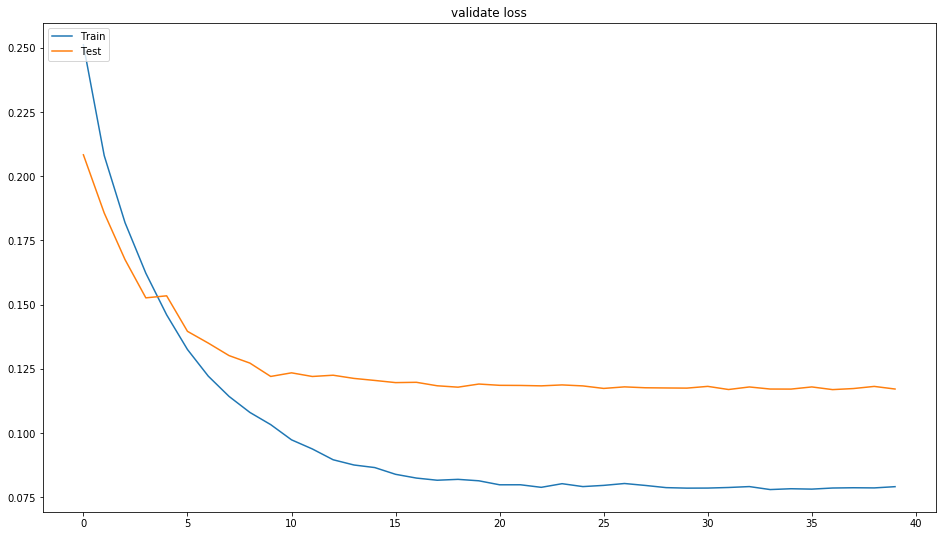

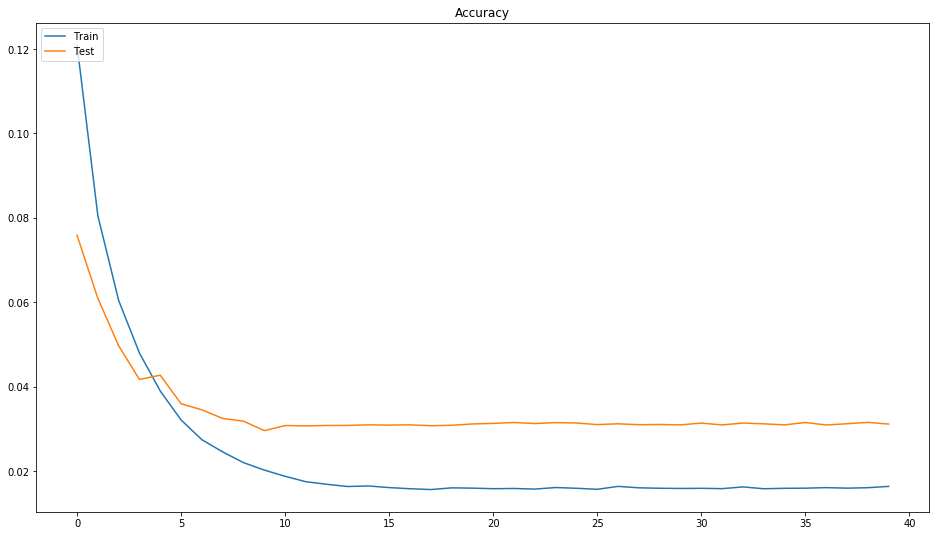

In [668]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('validate loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


plt.title('Accuracy')
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [669]:
results=model.predict(x_val)
y_predict_inv = scaler.inverse_transform(results)
y_test_inv = scaler.inverse_transform(y_val)

#Visualización Predicción para un tiempo
Output = pd.DataFrame()
Output['y_test'] = 0
Output['y_test'] = y_test_inv[0]
Output['y_predict'] = 0
Output['y_predict'] = y_predict_inv[0] 
Output['Diff'] = 0
Output['Diff'] = (y_test_inv[0] - y_predict_inv[0])
Output

y_test  y_predict      Diff
0      1.0   1.104155 -0.104155
1      6.0   2.889381  3.110619
2      3.0   0.784427  2.215573
3      7.0   9.380403 -2.380403
4      0.0   2.795860 -2.795860
5      0.0   0.785159 -0.785159
6      2.0   4.215717 -2.215717
7      0.0   0.002024 -0.002024
8      4.0   2.490981  1.509019
9      0.0   0.003001 -0.003001
10     1.0   0.000453  0.999547
11     0.0   0.043375 -0.043375
12     0.0   0.001412 -0.001412
13     0.0   0.223437 -0.223437

In [460]:
y_predict_inv = pd.DataFrame(y_predict_inv)
y_predict_inv.columns = df.columns
y_predict_inv

cuenta_dia                                              \
Sede Receptora   Aranjuez     Belén Buenos Aires Candelaria  Castilla   
0                2.661725  5.723881     1.564632  18.473799  4.348817   
1                2.397141  5.675604     1.078377  20.191969  4.914960   
2                2.718432  6.113109     1.596326  17.045107  4.287362   
3                1.853728  6.275021     1.285324  20.514975  4.818321   
4                2.277439  6.017112     1.214650  19.337942  4.227935   
..                    ...       ...          ...        ...       ...   
572              1.994228  3.519134     0.768831  15.201200  4.160001   
573              2.197543  6.137694     1.327375  18.821413  4.242723   
574              2.095193  4.739171     1.137315  16.259314  4.317683   
575              1.730082  4.594390     0.959766  16.691521  3.668603   
576              1.704484  4.961675     1.335611  15.354373  4.135467   

                                                                        \
Sede Receptora Doce de Octubre  Laureles  Manrique   Poblado   Popular   
0                     0.873249  8.252074  0.710399  5.374165  0.003370   
1                     0.827446  7.950210  0.374304  5.108347  0.012398   
2                     0.820140  7.868207  0.748480  5.443477  0.004226   
3                     1.208508  9.481491  0.944914  6.318046  0.006517   
4                     1.037464  8.314067  0.684903  5.234812  0.003120   
..                         ...       ...       ...       ...       ...   
572                   1.028798  6.157801  0.338867  3.995677  0.006476   
573                   0.926514  8.245050  0.739451  5.982691  0.005623   
574                   1.286744  7.180771  0.651588  4.513293 -0.008067   
575                   1.078824  7.310578  0.590075  4.784403 -0.002669   
576                   0.993965  7.711354  0.834248  4.810078  0.002841   

                                                                         
Sede Receptora San Antonio de Prado San Javier Santa Cruz Villa Hermosa  
0                          0.010822   0.734704   0.005071      1.011248  
1                          0.002610   0.748576   0.006030      0.883207  
2                          0.008723   0.690382   0.001526      0.740966  
3                          0.002307   0.557236   0.010285      0.828510  
4                          0.001955   0.785374   0.000813      0.872616  
..                              ...        ...        ...           ...  
572                        0.001505   0.436080   0.001837      0.417004  
573                        0.006134   0.600668   0.006734      0.600442  
574                        0.000967   0.528277  -0.008210      0.769369  
575                        0.000686   0.542887   0.008464      0.546548  
576                        0.011157   0.750855  -0.000041      0.725770  

[577 rows x 14 columns]

In [461]:
y_test_inv = pd.DataFrame(y_test_inv)
y_test_inv.columns = df.columns
y_test_inv

cuenta_dia                                         \
Sede Receptora   Aranjuez Belén Buenos Aires Candelaria Castilla   
0                     2.0   2.0          2.0        4.0      0.0   
1                     3.0   6.0          1.0       10.0      5.0   
2                     6.0   4.0          4.0       20.0     11.0   
3                     3.0   5.0          1.0       21.0      5.0   
4                     4.0  11.0          0.0       32.0      8.0   
..                    ...   ...          ...        ...      ...   
572                   3.0   8.0          0.0       23.0      5.0   
573                   3.0   7.0          0.0       23.0      5.0   
574                   5.0   4.0          6.0       16.0      6.0   
575                   3.0  12.0          3.0       44.0     10.0   
576                   5.0  16.0          2.0       29.0      7.0   

                                                                  \
Sede Receptora Doce de Octubre Laureles Manrique Poblado Popular   
0                          2.0      8.0      0.0     5.0     0.0   
1                          1.0      8.0      2.0     4.0     0.0   
2                          3.0      8.0      0.0     5.0     0.0   
3                          2.0      6.0      1.0     7.0     2.0   
4                          1.0     13.0      2.0    12.0     0.0   
..                         ...      ...      ...     ...     ...   
572                        2.0      8.0      0.0     6.0     0.0   
573                        1.0     10.0      1.0     8.0     0.0   
574                        1.0      2.0      1.0     4.0     0.0   
575                        4.0      6.0      2.0     3.0     1.0   
576                        0.0     10.0      1.0     2.0     2.0   

                                                                         
Sede Receptora San Antonio de Prado San Javier Santa Cruz Villa Hermosa  
0                               0.0        0.0        1.0           2.0  
1                               0.0        0.0        0.0           0.0  
2                               0.0        2.0        0.0           0.0  
3                               0.0        2.0        0.0           0.0  
4                               0.0        1.0        0.0           0.0  
..                              ...        ...        ...           ...  
572                             1.0        1.0        0.0           3.0  
573                             1.0        1.0        1.0           3.0  
574                             0.0        0.0        1.0           1.0  
575                             2.0        0.0        0.0           2.0  
576                             0.0        3.0        0.0           2.0  

[577 rows x 14 columns]

In [462]:
y_predict_inv.describe()


cuenta_dia                                                   \
Sede Receptora    Aranjuez       Belén Buenos Aires  Candelaria    Castilla   
count           577.000000  577.000000   577.000000  577.000000  577.000000   
mean              2.395292    5.636337     1.244864   18.653875    4.284806   
std               0.357745    0.777725     0.233149    2.884680    0.538788   
min               1.211391    3.459250     0.419089   10.404682    2.739568   
25%               2.162470    5.101164     1.093343   16.800114    3.936551   
50%               2.373919    5.648480     1.248772   18.669884    4.283041   
75%               2.607681    6.153097     1.404292   20.710428    4.641014   
max               3.802515    8.015360     1.979256   27.234886    5.776715   

                                                                    \
Sede Receptora Doce de Octubre    Laureles    Manrique     Poblado   
count               577.000000  577.000000  577.000000  577.000000   
mean                  0.979303    8.184618    0.661700    5.531137   
std                   0.159406    1.151314    0.200889    0.834699   
min                   0.499406    4.588194    0.040022    3.222014   
25%                   0.874845    7.412824    0.519523    4.987813   
50%                   0.971897    8.201392    0.652695    5.507662   
75%                   1.081053    8.983397    0.805049    6.066326   
max                   1.545432   12.142104    1.277816    8.923164   

                                                                         \
Sede Receptora     Popular San Antonio de Prado  San Javier  Santa Cruz   
count           577.000000           577.000000  577.000000  577.000000   
mean              0.002704             0.004815    0.704043    0.003868   
std               0.006726             0.003993    0.204188    0.004245   
min              -0.024397            -0.014114    0.139471   -0.013983   
25%              -0.000985             0.002307    0.561954    0.001540   
50%               0.003444             0.005058    0.701525    0.003871   
75%               0.007012             0.007347    0.838330    0.006627   
max               0.020507             0.016601    1.313905    0.015475   

                              
Sede Receptora Villa Hermosa  
count             577.000000  
mean                0.707706  
std                 0.223631  
min                 0.010567  
25%                 0.563275  
50%                 0.707710  
75%                 0.862727  
max                 1.427683

In [463]:
y_test_inv.describe()


cuenta_dia                                                   \
Sede Receptora    Aranjuez       Belén Buenos Aires  Candelaria    Castilla   
count           577.000000  577.000000   577.000000  577.000000  577.000000   
mean              4.332756    7.629116     2.117851   22.549393    6.608319   
std               4.668919    3.704499     1.650960    8.709912    3.148931   
min               0.000000    0.000000     0.000000    3.000000    0.000000   
25%               2.000000    5.000000     1.000000   17.000000    4.000000   
50%               4.000000    7.000000     2.000000   23.000000    6.000000   
75%               6.000000   10.000000     3.000000   28.000000    9.000000   
max              87.000000   34.000000     9.000000   54.000000   21.000000   

                                                                    \
Sede Receptora Doce de Octubre    Laureles    Manrique     Poblado   
count               577.000000  577.000000  577.000000  577.000000   
mean                  1.360485   11.604853    1.180243    8.185442   
std                   1.229710    6.951207    1.161637    3.928872   
min                   0.000000    1.000000    0.000000    0.000000   
25%                   0.000000    8.000000    0.000000    5.000000   
50%                   1.000000   11.000000    1.000000    8.000000   
75%                   2.000000   14.000000    2.000000   11.000000   
max                   6.000000   90.000000    7.000000   25.000000   

                                                                         \
Sede Receptora     Popular San Antonio de Prado  San Javier  Santa Cruz   
count           577.000000           577.000000  577.000000  577.000000   
mean              0.580589             0.381283    1.025997    0.464471   
std               0.833857             0.637538    1.116954    0.733051   
min               0.000000             0.000000    0.000000    0.000000   
25%               0.000000             0.000000    0.000000    0.000000   
50%               0.000000             0.000000    1.000000    0.000000   
75%               1.000000             1.000000    2.000000    1.000000   
max               5.000000             4.000000    9.000000    5.000000   

                              
Sede Receptora Villa Hermosa  
count             577.000000  
mean                1.409012  
std                 1.300022  
min                 0.000000  
25%                 0.000000  
50%                 1.000000  
75%                 2.000000  
max                 7.000000

In [625]:
df_temporal = pd.DataFrame()
df_temporal['dia']=[x.weekday() for x in df.index]
df_temporal['mes']=[x.month for x in df.index]
df_temporal['dia_sem']=[x.day for x in df.index]
df_temporal['year']=[x.year for x in df.index]
"""
values = df_temporal.values
values = values.astype('float32')
values = values[PASOS:]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

df_temporal = pd.DataFrame(scaled)
"""
values = df_temporal.values
values = values[PASOS:]


In [675]:
x_train2 = values[:n_train_days, :]
x_val2 = values[n_train_days:, :]
# split into input and outputs

# reshape input to be 3D [samples, timesteps, features]
x_train2 = x_train2.reshape((x_train2.shape[0], 1, x_train2.shape[1]))
x_val2 = x_val2.reshape(( x_val2.shape[0], 1, x_val2.shape[1]))
print(x_train.shape, x_val.shape)


(365, 1, 98) (1089, 1, 98)


# Con embedding temporal

In [676]:
EPOCHS = 40
inputs1 = Input(shape=[1, x_train.shape[2]])
inputs2 = Input(shape=[1, x_train2.shape[2]])


# serie de tiempo
x = Dense(PASOS,activation='selu')(inputs1)
x = Dropout(0.9)(x)
x = Dense(365, activation='selu')(x)
x = Dropout(0.9)(x)
x = Flatten()(x)

# Componente temporal
y = Embedding(2020, 64)(inputs2)
y = Dropout(0.5)(y)
y = Dense(48, activation='selu')(y)
y = Dropout(0.5)(y)
y = Flatten()(y)

# capas intermedias
dense = Dense(365, activation='selu')(concatenate([x, y], axis=1))
dense = Dropout(0.9)(dense)
dense = Dense(48, activation='selu')(dense)
dense = Dropout(0.2)(dense)
dense = Dense(24, activation='selu')(dense)
dense = Dropout(0.1)(dense)
predictions = Dense(14, activation='selu')(dense)

model = Model(inputs=[inputs1, inputs2], outputs=predictions)
model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
model.summary()
history2 =model.fit([x_train, x_train2], y_train,epochs=EPOCHS, batch_size=PASOS,
					validation_data=([x_val, x_val2], y_val))



Model: "model_157"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_422 (InputLayer)          (None, 1, 98)        0                                            
__________________________________________________________________________________________________
input_423 (InputLayer)          (None, 1, 112)       0                                            
__________________________________________________________________________________________________
dense_981 (Dense)               (None, 1, 7)         693         input_422[0][0]                  
__________________________________________________________________________________________________
embedding_122 (Embedding)       (None, 1, 112, 64)   129280      input_423[0][0]                  
__________________________________________________________________________________________

/home/david/jupyternot/local/lib/python3.5/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 365 samples, validate on 1089 samples
Epoch 1/40
365/365 [==============================] - 3s 9ms/step - loss: 0.9343 - mse: 1.4576 - val_loss: 0.3296 - val_mse: 0.1693
Epoch 2/40
365/365 [==============================] - 2s 5ms/step - loss: 0.6936 - mse: 0.8484 - val_loss: 0.1826 - val_mse: 0.0591
Epoch 3/40
365/365 [==============================] - 2s 6ms/step - loss: 0.5154 - mse: 0.5413 - val_loss: 0.1437 - val_mse: 0.0352
Epoch 4/40
365/365 [==============================] - 2s 5ms/step - loss: 0.4243 - mse: 0.4027 - val_loss: 0.1281 - val_mse: 0.0294
Epoch 5/40
365/365 [==============================] - 2s 5ms/step - loss: 0.3803 - mse: 0.3344 - val_loss: 0.1275 - val_mse: 0.0299
Epoch 6/40
365/365 [==============================] - 2s 5ms/step - loss: 0.3471 - mse: 0.2852 - val_loss: 0.1222 - val_mse: 0.0278
Epoch 7/40
365/365 [==============================] - 2s 5ms/step - loss: 0.2902 - mse: 0.2083 - val_loss: 0.1190 - val_mse: 0.0264
Epoch 8/40
365/365 [=========

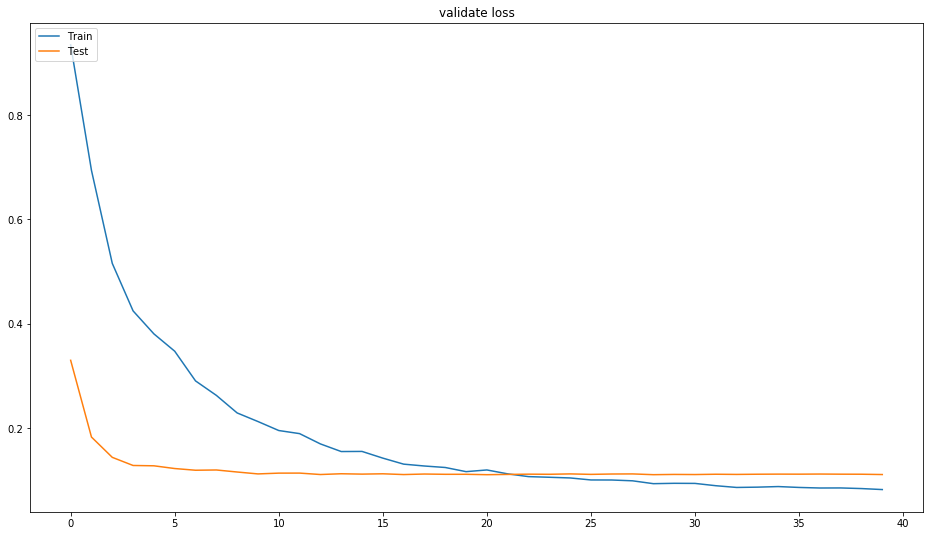

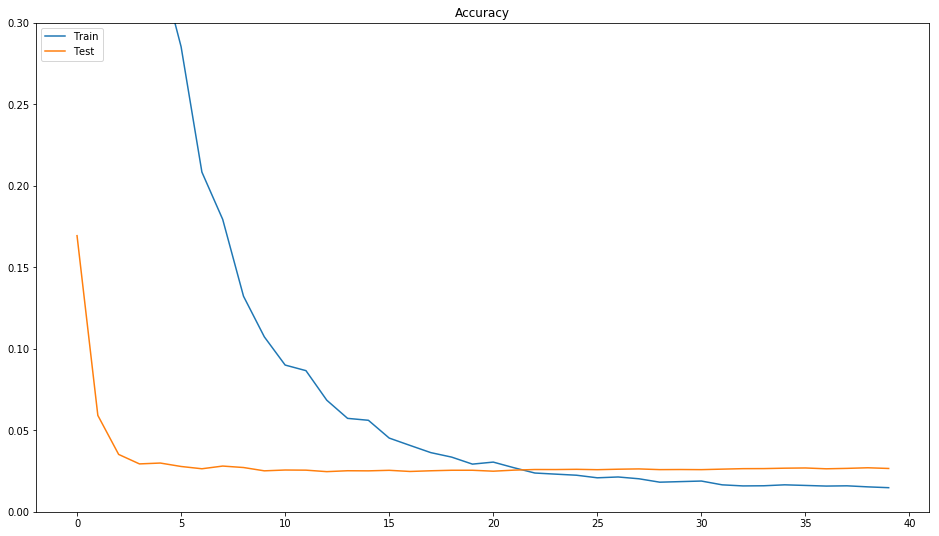

In [678]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('validate loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.ylim(0, 0.3)
plt.title('Accuracy')
plt.plot(history2.history['mse'])
plt.plot(history2.history['val_mse'])
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [700]:
results=model.predict([x_val, x_val2])
#compara = pd.DataFrame(np.array([y_val, [x[0]for x in results]])).transpose()
#results[0]

In [701]:
y_predict_inv = scaler.inverse_transform(results)
y_test_inv = scaler.inverse_transform(y_val)

#Visualización Predicción para un tiempo
Output = pd.DataFrame()
Output['y_test'] = 0
Output['y_test'] = y_test_inv[0]
Output['y_predict'] = 0
Output['y_predict'] = y_predict_inv[0] 
Output['Diff'] = 0
Output['Diff'] = (y_test_inv[0] - y_predict_inv[0])
Output

y_test  y_predict      Diff
0      1.0   1.790049 -0.790049
1      6.0   4.084977  1.915023
2      3.0   0.942835  2.057165
3      7.0  11.879318 -4.879318
4      0.0   3.893741 -3.893741
5      0.0   0.917048 -0.917048
6      2.0   5.354494 -3.354494
7      0.0   0.381227 -0.381227
8      4.0   3.431114  0.568886
9      0.0   0.233713 -0.233713
10     1.0   0.042628  0.957372
11     0.0   0.467077 -0.467077
12     0.0   0.070112 -0.070112
13     0.0   0.555242 -0.555242

In [703]:
y_predict_inv = pd.DataFrame(y_predict_inv)
y_predict_inv.columns = df.columns
y_predict_inv.describe()

cuenta_dia                                         \
Sede Receptora     Aranjuez        Belén Buenos Aires   Candelaria   
count           1089.000000  1089.000000  1089.000000  1089.000000   
mean               1.744284     4.033549     0.941504    12.013297   
std                0.027482     0.036590     0.013238     0.100891   
min                1.659869     3.870840     0.889512    11.683345   
25%                1.727122     4.012607     0.933462    11.946083   
50%                1.743603     4.035950     0.942182    12.007058   
75%                1.760632     4.058370     0.949226    12.074541   
max                1.841203     4.140145     1.002003    12.630434   

                                                                       \
Sede Receptora     Castilla Doce de Octubre     Laureles     Manrique   
count           1089.000000     1089.000000  1089.000000  1089.000000   
mean               3.915344        0.909277     5.332576     0.369726   
std                0.028571        0.008110     0.018011     0.011445   
min                3.789242        0.866164     5.224681     0.321219   
25%                3.896841        0.904363     5.324003     0.362610   
50%                3.916355        0.910502     5.335233     0.370827   
75%                3.934084        0.914794     5.345209     0.377754   
max                4.022111        0.934373     5.379131     0.399788   

                                                                            \
Sede Receptora      Poblado      Popular San Antonio de Prado   San Javier   
count           1089.000000  1089.000000          1089.000000  1089.000000   
mean               3.486048     0.214591             0.041367     0.504577   
std                0.030935     0.015452             0.001502     0.017421   
min                3.365443     0.160375             0.032036     0.436036   
25%                3.466344     0.205328             0.040406     0.493220   
50%                3.486866     0.214671             0.041412     0.503659   
75%                3.506224     0.224324             0.042338     0.515365   
max                3.576079     0.266537             0.046921     0.565231   

                                           
Sede Receptora   Santa Cruz Villa Hermosa  
count           1089.000000   1089.000000  
mean               0.062110      0.531341  
std                0.005170      0.013761  
min                0.039265      0.475039  
25%                0.058829      0.523151  
50%                0.062373      0.531854  
75%                0.065601      0.540120  
max                0.077716      0.576298

In [707]:
y_test_inv = pd.DataFrame(y_test_inv)
y_test_inv.columns = df.columns
y_test_inv.describe()


cuenta_dia                                         \
Sede Receptora     Aranjuez        Belén Buenos Aires   Candelaria   
count           1089.000000  1089.000000  1089.000000  1089.000000   
mean               3.439853     6.797061     1.798898    20.556475   
std                3.727421     3.723701     1.536013     8.388475   
min                0.000000     0.000000     0.000000     2.000000   
25%                2.000000     4.000000     1.000000    14.000000   
50%                3.000000     6.000000     2.000000    21.000000   
75%                5.000000     9.000000     3.000000    25.999998   
max               87.000000    46.000000     9.000000    54.000000   

                                                                       \
Sede Receptora     Castilla Doce de Octubre     Laureles     Manrique   
count           1089.000000     1089.000000  1089.000000  1089.000000   
mean               5.671258        1.146006    10.040404     0.988062   
std                3.041126        1.125321     6.023867     1.061026   
min                0.000000        0.000000     1.000000     0.000000   
25%                4.000000        0.000000     6.000000     0.000000   
50%                5.000000        1.000000     9.000000     1.000000   
75%                7.000000        2.000000    13.000000     2.000000   
max               21.000000        6.000000    90.000000     7.000000   

                                                                            \
Sede Receptora      Poblado      Popular San Antonio de Prado   San Javier   
count           1089.000000  1089.000000          1089.000000  1089.000000   
mean               6.977962     0.492195             0.334252     0.869605   
std                3.821075     0.742724             0.588127     1.001600   
min                0.000000     0.000000             0.000000     0.000000   
25%                4.000000     0.000000             0.000000     0.000000   
50%                6.000000     0.000000             0.000000     1.000000   
75%                9.000000     1.000000             1.000000     1.000000   
max               25.000000     5.000000             4.000000     9.000000   

                                           
Sede Receptora   Santa Cruz Villa Hermosa  
count           1089.000000   1089.000000  
mean               0.406795      1.120294  
std                0.670265      1.191746  
min                0.000000      0.000000  
25%                0.000000      0.000000  
50%                0.000000      1.000000  
75%                1.000000      2.000000  
max                5.000000      7.000000

In [708]:
from kmodes.kmodes import KModes
from sklearn.preprocessing import LabelEncoder
data = datos[datos['ano'] > 2015].drop(['Caso Hurto','Hora Hurto', 'Minuto Hurto',
                                        'Responsable Indicador', 'Responsable Indicador', 'Barrio',
                                       'Comuna', 'Asegurado Hurto', 'Linea Marca Hurto', 
                                        'Marca', 'Color', 'Fecha Actualización Hurto', 'ano',
                                       'Modelo Hurto', 'Placa Hurto'], axis=1)
data= data.fillna('0')
data.head()


Año        Día Día nombre Mes Calendario Jornada Nombre Bien Sijin Hurto  \
5   2018 2018-01-01      Lunes          Enero   Noche  LICENCIA DE CONDUCCION   
7   2018 2018-01-01      Lunes          Enero   Noche          ZAPATILLA/TENI   
9   2018 2018-01-01      Lunes          Enero   Noche    TARJETA DE PROPIEDAD   
10  2018 2018-01-01      Lunes          Enero   Tarde                 CELULAR   
14  2018 2018-01-01      Lunes          Enero   Noche                 CELULAR   

                       Bien                  Categoría Bien Grupo Bien  \
5                  Licencia                      Documentos  Mercancía   
7                   Zapatos  Prendas de vestir y accesorios  Mercancía   
9   Tarjeta para computador                      Tecnología  Mercancía   
10                  Celular                      Tecnología  Mercancía   
14                  Celular                      Tecnología  Mercancía   

   Conducta Especial  ...               Cuadrante                 Lugar  \
5           Sin dato  ...  MEVALPNVCCD02E01000040           Vía pública   
7                 No  ...  MEVALPNVCCD02E01000008           Vía pública   
9                 No  ...  MEVALPNVCCD05E02000019  Conjunto residencial   
10                No  ...  MEVALPNVCCD03E01000008                Parque   
14        De celular  ...  MEVALPNVCCD05E01000010           Restaurante   

     Grupo Lugar  Valor Hurto Estado Civil Medio Transporte  \
5     Transporte       139100   Soltero(a)             Taxi   
7     Transporte       280000   Soltero(a)        Automóvil   
9   Habitacional        80000   Soltero(a)         Caminata   
10          Otro       350000   Soltero(a)         Caminata   
14     Económica      1200000   Soltero(a)         Caminata   

      Medio Transporte Agresor  Sede Receptora  Grupo Sede Receptora  \
5                     Caminata        Castilla              Estación   
7   Motocicleta con parrillero        Castilla              Estación   
9                     Caminata           Belén              Estación   
10                    Caminata      Candelaria              Estación   
14                    Caminata         Poblado              Estación   

            Arma Medio  
5        Arma de fuego  
7        Arma de fuego  
9                   No  
10  Arma cortopunzante  
14                  No  

[5 rows x 31 columns]

In [709]:
lb_make = LabelEncoder()
for value in data.columns:
    data[value] = lb_make.fit_transform(data[value].values.tolist())


In [434]:
k_cluster = 10
cost = []
for num_clusters in list(range(1,k_cluster)):
    kmode = KModes(n_clusters=num_clusters, init = "Cao", n_init = 1, verbose=1)
    kmode.fit_predict(data)
    cost.append(kmode.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 1523549.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 9792, cost: 1463821.0
Run 1, iteration: 2/100, moves: 1363, cost: 1463821.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 9161, cost: 1441235.0
Run 1, iteration: 2/100, moves: 1478, cost: 1441235.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 14315, cost: 1416086.0
Run 1, iteration: 2/100, moves: 1451, cost: 1416086.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 16577, cost: 1404949.0
Run 1, iteration: 2/100, moves: 1342, cost: 1404689.0
Run 1, iteration: 3/100, moves: 108, cost: 1404689.0
Init: initializing centroids
Init: initializing clusters
Start

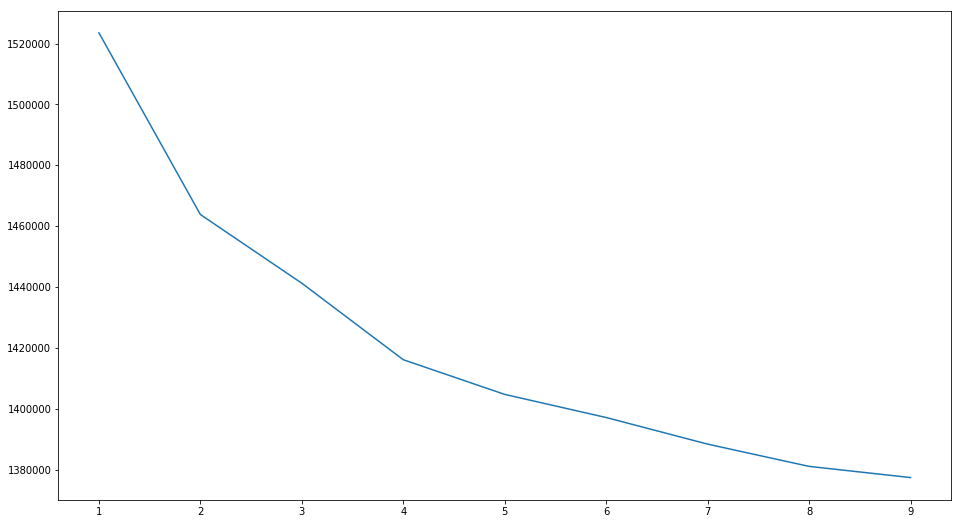

In [435]:
y = np.array([i for i in range(1,k_cluster,1)])
plt.plot(y,cost)

In [444]:
#Se crea la nueva característica.
k_clusters = 4
kmodes = KModes(n_clusters=k_clusters, init = "Huang", n_init = 1, verbose=1)
y_kmodes = kmodes.fit_predict(data)
y_kmodes = y_kmodes.reshape(-1,1)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 27072, cost: 1481373.0
Run 1, iteration: 2/100, moves: 1655, cost: 1481373.0


In [445]:
print('Tamaño base de datos',data.shape)
print('Tamaño nueva variable por Kmodes',y_kmodes.shape)
data['kmodes'] = y_kmodes

Tamaño base de datos (79556, 32)
Tamaño nueva variable por Kmodes (79556, 1)


In [465]:
data_kmodes = data[['kmodes', 'Día']]
#data_kmodes['dia'] = data[['kmodes']]

# use pd.concat to join the new columns with your original dataframe
data_kmodes = pd.concat([data_kmodes,pd.get_dummies(data_kmodes['kmodes'], prefix='k')],axis=1)

# now drop the original 'country' column (you don't need it anymore)
data_kmodes.drop(['kmodes'],axis=1, inplace=True)
data_kmodes

Día  k_0  k_1  k_2  k_3
5        731    1    0    0    0
7        731    1    0    0    0
9        731    0    0    0    1
10       731    0    1    0    0
14       731    0    0    1    0
...      ...  ...  ...  ...  ...
206442  1460    0    1    0    0
206443  1460    0    1    0    0
206444  1460    0    1    0    0
206445  1460    0    1    0    0
206447  1460    0    1    0    0

[79556 rows x 5 columns]

In [466]:
data_kmodes = data_kmodes.groupby('Día').sum()

data_kmodes

k_0  k_1  k_2  k_3
Día                     
0       1    4    4    3
1       4   12    3    2
2       6    6    5    1
3       4   17    3    3
4       5   12    0    1
...   ...  ...  ...  ...
1456   13   16   12   19
1457   15   23   13   13
1458    9   27    9    2
1459   15   42   12   23
1460   13   51    4   11

[1461 rows x 4 columns]

In [503]:
values = data_kmodes.values
values = values.astype('float32')
values = values[PASOS:]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

df_temporal = pd.DataFrame(scaled)

values = df_temporal.values

In [504]:
x_train_kmoda = values[:n_train_days, :]
x_val2_kmoda = values[n_train_days:, :]
# split into input and outputs

# reshape input to be 3D [samples, timesteps, features]
x_train_kmoda = x_train_kmoda.reshape((x_train_kmoda.shape[0], 1, x_train_kmoda.shape[1]))
x_val2_kmoda = x_val2_kmoda.reshape((x_val2_kmoda.shape[0], 1, x_val2_kmoda.shape[1]))
print(x_train_kmoda.shape, x_val2_kmoda.shape)

(365, 1, 4) (1089, 1, 4)


# Con embedding y kmodas

In [712]:
EPOCHS = 120
inputs1 = Input(shape=[1, x_train.shape[2]])
inputs2 = Input(shape=[1, x_train2.shape[2]])
inputs3 = Input(shape=[1, x_train_kmoda.shape[2]])

# serie de tiempo
x = Dense(PASOS,activation='selu')(inputs1)
x = Dropout(0.8)(x)
x = Dense(365, activation='selu')(x)
x = Dropout(0.9)(x)
x = Flatten()(x)

# Componente temporal
#y = Dense(PASOS, activation='relu')(inputs2)
y = Embedding(2020, 48)(inputs2)
y = Dropout(0.5)(y)
y = Dense(48, activation='selu')(y)
y = Dropout(0.5)(y)
y = Flatten()(y)

# componente kmodas
moda = LSTM(365, input_shape=(1, x_train_kmoda.shape[2]), return_sequences=True)(inputs3)
moda = Dropout(0.8)(moda)
moda = Dense(48, activation='selu')(moda)
moda = Dropout(0.2)(moda)
moda = Flatten()(moda)

# capas intermedias
dense = Dense(365, activation='selu')(concatenate([x, y, moda], axis=1))
dense = Dropout(0.9)(dense)
dense = Dense(48, activation='selu')(dense)
dense = Dropout(0.2)(dense)
dense = Dense(24, activation='selu')(dense)
#dense = Dropout(0.2)(dense)
predictions = Dense(14, activation='selu')(dense)

model = Model(inputs=[inputs1, inputs2, inputs3], outputs=predictions)
model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
model.summary()
history2 =model.fit([x_train, x_train2, x_train_kmoda], y_train,epochs=EPOCHS, batch_size=PASOS,
					validation_data=([x_val, x_val2, x_val2_kmoda], y_val))

Model: "model_158"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_424 (InputLayer)          (None, 1, 98)        0                                            
__________________________________________________________________________________________________
input_425 (InputLayer)          (None, 1, 112)       0                                            
__________________________________________________________________________________________________
input_426 (InputLayer)          (None, 1, 4)         0                                            
__________________________________________________________________________________________________
dense_988 (Dense)               (None, 1, 7)         693         input_424[0][0]                  
__________________________________________________________________________________________

/home/david/jupyternot/local/lib/python3.5/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 365 samples, validate on 1089 samples
Epoch 1/120
365/365 [==============================] - 4s 10ms/step - loss: 0.9077 - mse: 1.2569 - val_loss: 0.2298 - val_mse: 0.0889
Epoch 2/120
365/365 [==============================] - 2s 6ms/step - loss: 0.6212 - mse: 0.6332 - val_loss: 0.1657 - val_mse: 0.0481
Epoch 3/120
365/365 [==============================] - 2s 7ms/step - loss: 0.4883 - mse: 0.4006 - val_loss: 0.1354 - val_mse: 0.0340
Epoch 4/120
365/365 [==============================] - 2s 6ms/step - loss: 0.3667 - mse: 0.2462 - val_loss: 0.1194 - val_mse: 0.0254
Epoch 5/120
365/365 [==============================] - 2s 7ms/step - loss: 0.2995 - mse: 0.1756 - val_loss: 0.1185 - val_mse: 0.0261
Epoch 6/120
365/365 [==============================] - 2s 6ms/step - loss: 0.2379 - mse: 0.1113 - val_loss: 0.1201 - val_mse: 0.0260
Epoch 7/120
365/365 [==============================] - 2s 6ms/step - loss: 0.2013 - mse: 0.0810 - val_loss: 0.1124 - val_mse: 0.0240
Epoch 8/120
365/365 [

Epoch 62/120
365/365 [==============================] - 2s 6ms/step - loss: 0.0757 - mse: 0.0128 - val_loss: 0.0927 - val_mse: 0.0196
Epoch 63/120
365/365 [==============================] - 2s 6ms/step - loss: 0.0763 - mse: 0.0130 - val_loss: 0.0931 - val_mse: 0.0199
Epoch 64/120
365/365 [==============================] - 2s 6ms/step - loss: 0.0759 - mse: 0.0128 - val_loss: 0.0954 - val_mse: 0.0208
Epoch 65/120
365/365 [==============================] - 2s 6ms/step - loss: 0.0758 - mse: 0.0130 - val_loss: 0.0960 - val_mse: 0.0210
Epoch 66/120
365/365 [==============================] - 2s 6ms/step - loss: 0.0766 - mse: 0.0131 - val_loss: 0.0910 - val_mse: 0.0188
Epoch 67/120
365/365 [==============================] - 2s 6ms/step - loss: 0.0761 - mse: 0.0129 - val_loss: 0.0937 - val_mse: 0.0195
Epoch 68/120
365/365 [==============================] - 2s 6ms/step - loss: 0.0760 - mse: 0.0129 - val_loss: 0.0936 - val_mse: 0.0198
Epoch 69/120
365/365 [==============================] - 2s 6ms

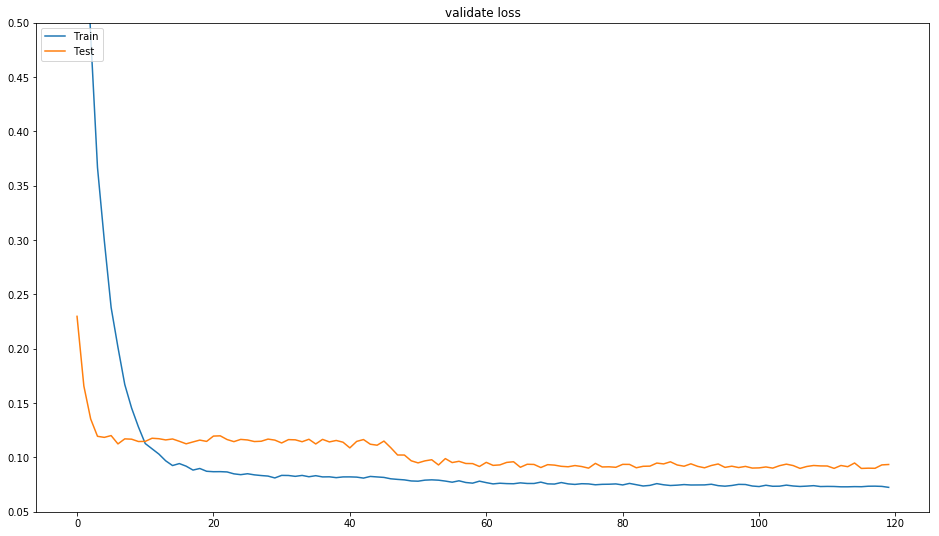

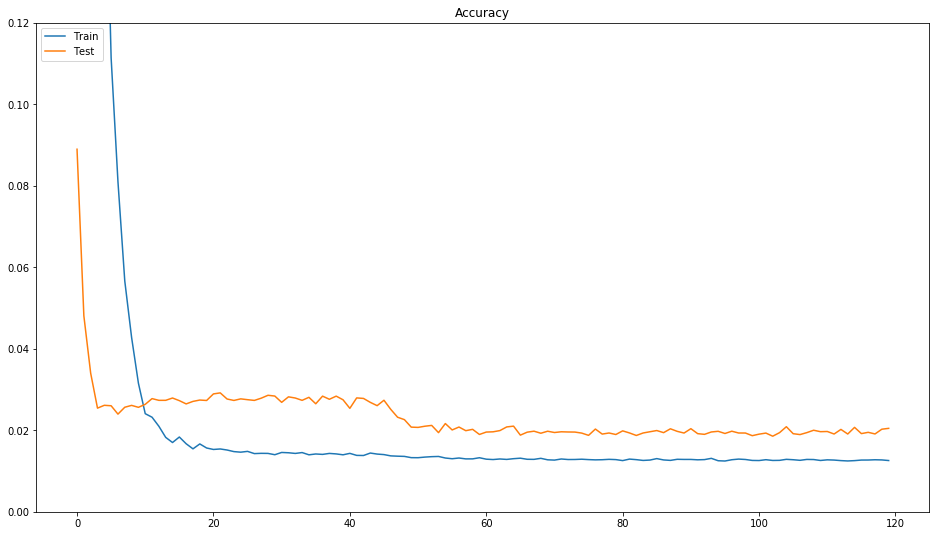

In [713]:
plt.ylim(0.05, 0.5)

plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('validate loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.ylim(0, 0.12)
plt.title('Accuracy')
plt.plot(history2.history['mse'])
plt.plot(history2.history['val_mse'])
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()